In [14]:
# Quantum Machine Learning for Conspicuity Detection in Production --> Womanium + Fraunhofer ITWM
#
# Student: Marcia Hon (marcia.hon.29@gmail.com)
#
# Question 3
# (necessary to pass the project) Consider a more sophisticated model using
# an interesting real-world dataset (here the MNIST dataset), Quanvolutional
# Neural Networks. Work through the example, Implement and present your
# steps in a notebook and comment on the important steps.
#
# Reference: https://pennylane.ai/qml/demos/tutorial_quanvolution/

In [15]:
# Introduction
#
# Quanvolutional Neural Networks
#
# Classical Convolution
# This is the Neural Network done on classical computers. Its main usage
# is in processing images. Essentially, at the different layers of the
# neural network, kernels are done in order to obtain image characteristics
# such as circle/edges/etc. This is known as Convolutions. Following the
# kernel, there is max pooling which reduces the image size. This pair of
# procedures are repeated a few times. Then there is a layer that classifies
# the image as, for example, a dog/cat/car.
#
# Quantum Convolution
# The same idea as Classical Convolution can be applied to the context of
# Quantum Variational Circuits. Essentially, the following is the procedure:
#    1. A small region of input image is embedded.
#    2. A quantum computation is done with a unitary matrix.
#    3. Then, finally, the system is measured.
#    4. The expections are mapped to an output channel.
#    5. This procedure is repeated over different images of the image.
#    6. Quantum convolution can be followed by quantum/classical layers.
#
# Difference between Classical and Quantum Convolution
# The main difference between classical and quantum, is that with quantum,
# the circuit can be highly complex kernels with calculations that can be
# classically intractable.

In [16]:
# GENERAL SETUP
# First, we must import the appropriate libraries.
# Most specifically, pennylane, tensorflow and matplotlib.
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [17]:
# SETTING OF THE MAIN HYPER-PARAMETERS OF THE MODEL
# Setup the main hyper-parameters of the model.
# Train is 62.5% and Test is 37.5%.
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "./"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [18]:
# LOADING OF THE MNIST DATASET
# Now, we import the MNIST dataset from the server.
# This dataset already is divided into test and train.
# We reduce the test/train quantity to our own: 50/30.
# The image pixels are normalized to between 0 and 1 in order to make
# calculations more consistent. Finally, an extra dimension is added for
# a convolution channel.
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [19]:
# QUANTUM CIRCUIT AS A CONVOLUTIONAL KERNEL
# Now, we initialized PennyLane to "default.qubit"
# that has a system of 4 qubits. Then a qnode is created
# to behave as a convolution kernel. This circuit consists of the following:
#
#    1. Embedding layer of local RY rotations (angles factor of PI)
#    2. Random circuit of n_layers
#    3. Final measurement with 4 expectation values
#
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [20]:
# CONVOLUTION SCHEME
#
# quanv(image) does the following:
#
#    1. Divide image into squares of 2x2 pixels.
#    2. Each square is processed by the quantumm circuit.
#    3. 4 expectations are calculated and mapped to 4 channels.
#
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [21]:
# QUANTUM PRE-PROCESSING OF THE DATASET
# The Quantum Convolution Layer is now going to be trained. Thus, it is more
# efficient to apply it as a "preprocessing" layer. Then, a classical
# model will be trained and tested on the pre-processed dataset. This avoids
# repetitions of quantum computations.
# The pre-processed images are saved in the folder "SAVE_PATH". Once saved,
# images could be downloaded from this folder.
#
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


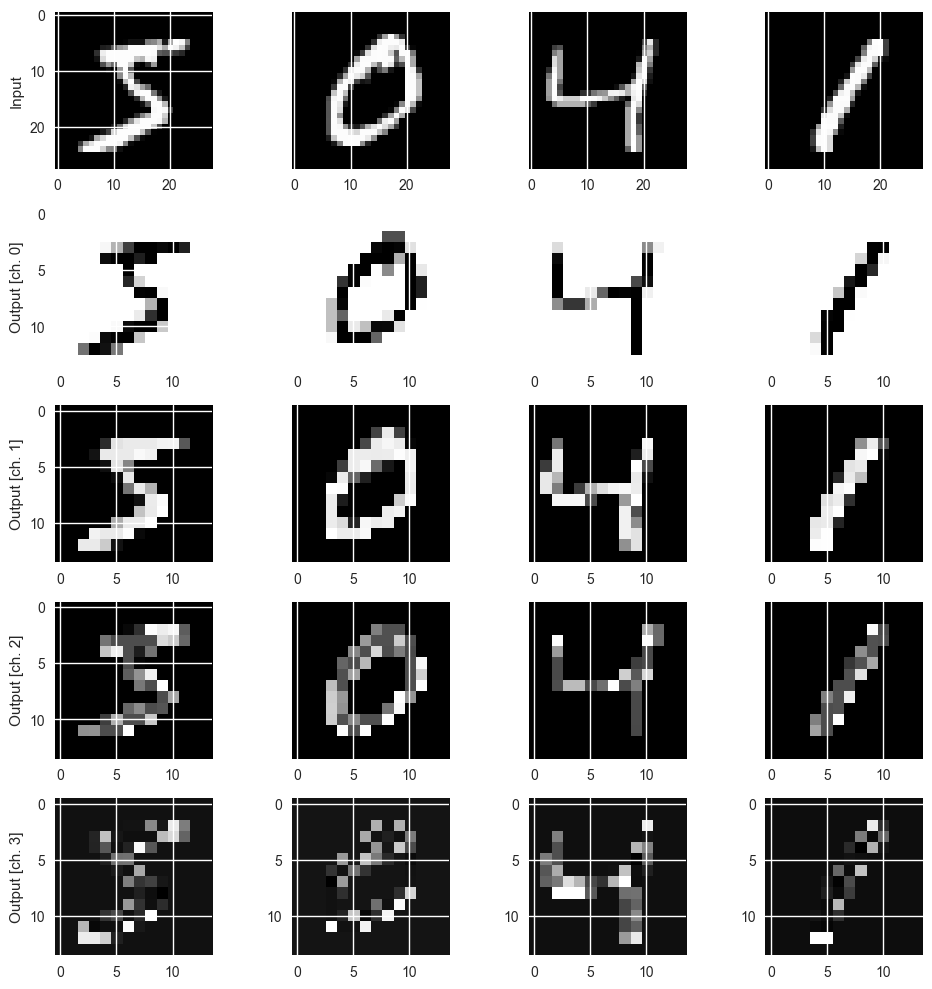

In [22]:
# VISUALIZATION OF QUANTUM CONVOLUTION LAYER ON A BATCH OF SAMPLES
# The top image are the originals. Below, are the 4 output channels by
# the Quantum Convolution. Clearly, there is downsampling of resolution and
# some distortion. Most importantly, the global essence of the image is
# maintained.
#
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [23]:
# HYBRID QUANTUM-CLASSICAL MODEL
# After the quantum convolutional layer, the features are fed into
# a classical neural network that is trained to classify the 10 digits of
# MNIST. It is very simple - fully connected layer, 10 outputs, and a final
# softmax activation function. Additionally, stochastic-gradient-descent
# optimizer is used along with a cross-entropy loss function.
def MyModel():

    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [24]:
# TRAINING
# The model is initialized. Then, train and validate using the dataset
# that was pre-processed by the quantum convolution.
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 68ms/step - accuracy: 0.1000 - loss: 2.7240 - val_accuracy: 0.1333 - val_loss: 2.0873
Epoch 2/30
13/13 - 0s - 7ms/step - accuracy: 0.3800 - loss: 1.8534 - val_accuracy: 0.3333 - val_loss: 1.9438
Epoch 3/30
13/13 - 0s - 7ms/step - accuracy: 0.7000 - loss: 1.5606 - val_accuracy: 0.3667 - val_loss: 1.8333
Epoch 4/30
13/13 - 0s - 7ms/step - accuracy: 0.7800 - loss: 1.2591 - val_accuracy: 0.5667 - val_loss: 1.6562
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.9000 - loss: 1.0258 - val_accuracy: 0.6000 - val_loss: 1.5378
Epoch 6/30
13/13 - 0s - 9ms/step - accuracy: 0.9200 - loss: 0.8521 - val_accuracy: 0.6000 - val_loss: 1.4621
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9200 - loss: 0.7146 - val_accuracy: 0.6000 - val_loss: 1.3939
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 0.6047 - val_accuracy: 0.6333 - val_loss: 1.3353
Epoch 9/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.5161 - val_accuracy: 0.6333 - val_loss: 1.2896
Epoch 10/30
13/13 

In [25]:
# TRAINING
# In order to compare the results, we also perform a classical convolution
# that uses the raw MNIST images (ie without quantum pre-processing).
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 60ms/step - accuracy: 0.0400 - loss: 2.4016 - val_accuracy: 0.1000 - val_loss: 2.3373
Epoch 2/30
13/13 - 0s - 6ms/step - accuracy: 0.2200 - loss: 2.0071 - val_accuracy: 0.1333 - val_loss: 2.1738
Epoch 3/30
13/13 - 0s - 8ms/step - accuracy: 0.5600 - loss: 1.7201 - val_accuracy: 0.3000 - val_loss: 2.0191
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.8400 - loss: 1.4763 - val_accuracy: 0.4333 - val_loss: 1.8780
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.9000 - loss: 1.2690 - val_accuracy: 0.4667 - val_loss: 1.7551
Epoch 6/30
13/13 - 0s - 9ms/step - accuracy: 0.9200 - loss: 1.0947 - val_accuracy: 0.5000 - val_loss: 1.6517
Epoch 7/30
13/13 - 0s - 11ms/step - accuracy: 0.9400 - loss: 0.9496 - val_accuracy: 0.5333 - val_loss: 1.5659
Epoch 8/30
13/13 - 0s - 8ms/step - accuracy: 0.9400 - loss: 0.8293 - val_accuracy: 0.5333 - val_loss: 1.4949
Epoch 9/30
13/13 - 0s - 7ms/step - accuracy: 0.9400 - loss: 0.7293 - val_accuracy: 0.5667 - val_loss: 1.4359
Epoch 10/30
13/1

C:\Users\marci\AppData\Local\Temp\ipykernel_2744\3523403393.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


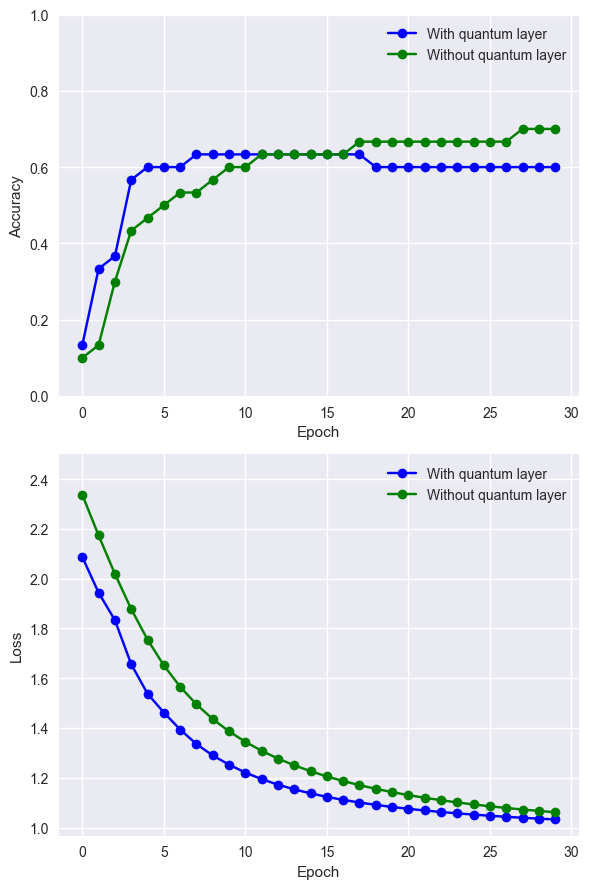

In [26]:
# RESULTS
# We plot the accuracy and test loss with respect to the training epochs
# number. We can see, that the two types of convolution achieve similar
# results. With regards to accuracy, there they are very close and, in fact,
# match. With regards to Loss, again they are close, however, "without
# quantum layer" performs slightly better.
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()